This file, intended for Python 2.7, reads in raw output from GP Microbiome and processes it, saving the data to csv files for use in other programs in this repository with up-to-date versions of Python. It is written for Python 2.7 because it processes output from a Python 2.7 program. 

<br>
Although technically it is possible to load a file pickled in Python 2 with Python 3, compatibility issues between the two versions of pickle make this far from straightforward. Furthermore, since the program processes output from a Python 2.7 program, Python 2.7 will already be installed on your computer if you are running this on your own data.

In [1]:
#import libraries
import pickle
import pandas as pd
import numpy as np

This code uses the output file 'example_output.p', created from running GP Microbiome on the example_data input files. The example GP Microbiome input files (in the Data folder under 'Extras') include absolute abundances of 6 OTU's (operational taxonomic units) of bacteria at 10 time points, and a set of 13 predicted time points: 10 of these are between sample time points and 3 are in the future. Although the code is written to save the output to csv files after procesing, if you are only running it on this example data, you don't need to save. My other programs use example data that looks very similar to the output of this program when it was run on our CF data, with 245 OTU's. 

The code is written to allow the user to do some initial exploration of this raw output, as I did the first time I processed output from GP Microbiome. Don't feel like exploring the data? At the end of the program is a function that performs all the necessary processing at once, and it can be used in a loop to process multiple raw output files, creating and saving their csv counterparts with one run. 

When I created my GP Microbiome input files for the time points and prediction time points, I formatted them as time deltas, with units of days, for all but the first participant I ran the program on. For that participant (ID number 151), I used their age in days at the time points and predicted time points. After viewing the output from that first run of GP Microbiome, I decided that I preferred using time deltas because it facilitates side-by-side comparison of different participant's output tables. 

<br>

When running the same program on multiple participants, as I did with GP Microbiome, I believe it is best practice to make the same formatting choices for each participant whenever possible. This facilitates comparison, prevents errors, and allows for simpler code. With this in mind, and because the output of this program becomes input for my plotting programs, I include in this repository a version of this program called readsample27_with_151_edit to show how I created all the files at once while correcting the discrepancy in the output file samples_151.p (from participant 151), and could have corrected for any other file which did not use time deltas. It transforms 151's time points into time deltas before creating the csv versions of the output files so that they match the others' formatting from this point on. At the end of that program, I include a comment with an 'if' statement which could have been inserted into my plotting functions, to illustrate how I could have handled this discrepancy another way. However, I prefer to make my formatting consistent in the files themselves rather than insert such a statement every time I run a program that uses the files as input.  

<br>

All of my code is written to be adaptable yet highly resistant to errors. However you choose to define your time points, take similar steps to ensure that, when you run functions like the ones in my plotting programs which generate 20 plots per participant simultaneously for multiple participants, those plots show exactly what they are intended to show. 

In [20]:
T,T_p,samples = pickle.load(open('Data/example_output.p','r'))

The keys for the information in the output dictionary file are:    
    <br>
        'G_d', 'G_i', 'F', 'Beta', 'eta_sq', 'inv_rho_sq', 'sigma_sq', 'rho_sq', 'Theta_G', 'Theta_G_i', and 'lp__',
    <br>
    
with 'Theta_G_i' only appearing if predictions are made.

In [ ]:
#view the list of the variables in the output file for yourself, if desired
print samples.keys()

In [ ]:
#print the means of the Theta_G variable, and the Theta_G_i variable if predictions have been made
print samples['Theta_G'].mean(0).T
if samples.has_key('Theta_G_i'):
  print samples['Theta_G_i'].mean(0).T

Example Output, using the sample data with 10 time points and 13 prediction time points for 6 OTU's. 
<br>
Blue arrows indicate where the arrays for Theta_G and Theta_G_i begin.
<img src='https://i.imgur.com/IETB4LK.png' style='height:400px'>

In [6]:
#Examine the time points array to make sure it was saved correctly. 
#Our project used timepoints based on the number of days since the first sample, so I did the same for the example file. 
T

array([   0.,  442.,  620.,  879.,  991., 1087., 1255., 1379., 1492.,
       1617.])

In [7]:
#Convert the array to a list
T=T.tolist()

In [8]:
#Examine the prediction time points array to make sure it was saved correctly
T_p

array([ 147.,  294.,  531.,  749.,  935., 1039., 1171., 1317., 1435.,
       1554., 1797., 1977., 2157.])

In [9]:
#Convert the array to a list
T_p=T_p.tolist()

In [10]:
#Make a single list for both sets of time points, for reference 
T_both = T+T_p
#view list
print T_both

[0.0, 442.0, 620.0, 879.0, 991.0, 1087.0, 1255.0, 1379.0, 1492.0, 1617.0, 147.0, 294.0, 531.0, 749.0, 935.0, 1039.0, 1171.0, 1317.0, 1435.0, 1554.0, 1797.0, 1977.0, 2157.0]


In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

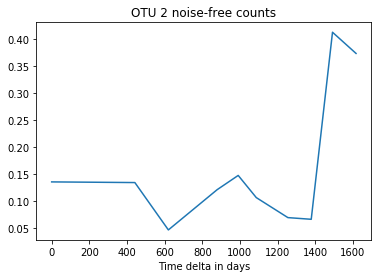

In [12]:
#Do a quick exploratory plot of one of the OTU's, specifying y-axis limits if desired
plt.plot(T,samples['Theta_G'].mean(0).T[1])
plt.title('OTU 2 noise-free counts')
plt.xlabel('Time delta in days')
#plt.ylim(0.025,.425)
plt.show()

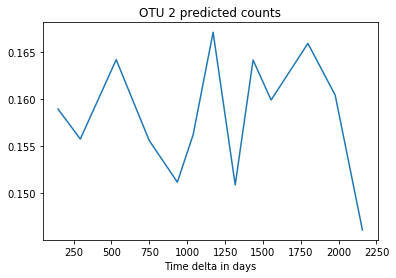

In [13]:
#Do a second quick plot, of the predicted values for the same OTU, in the same fashion
plt.plot(T_p,samples['Theta_G_i'].mean(0).T[1])
plt.title('OTU 2 predicted counts')
plt.xlabel('Time delta in days')
#plt.ylim(0.025,.425)
plt.show()

In [14]:
#Assign to the variable 'rows' the number of rows in the output array, which is the number of OTU's of bacteria
rows=len(samples['Theta_G'].mean(0).T)


In [ ]:
#Create a data frame with the timepoints in the first row and the OTU's in the following rows
df=pd.DataFrame(samples['Theta_G'].mean(0).T, columns=[i for i in range(len(T))], index=[i+1 for i in range(rows)])
df.loc[0] = T
df=df.sort_index()
df.head()

Example data frame using the sample data
<img src='https://i.imgur.com/6U9XUzO.png' style='height:160px'>

In [14]:
#Save to csv for re-importing into code using an up-to-date version of Python. 
#As I mentioned earlier, there's no need to save the example data. 
#You will want to save the files if you run the program on your own output data. 
#Remember to specify a file path if you want it in a particular folder on your computer.
df.to_csv('Data/example.csv', index=False)

In [ ]:
#Create a second data frame for just the prediction time points and values, with the same format as before but column values starting 
#after the last value of the other data frame's columns
df2=pd.DataFrame(samples['Theta_G_i'].mean(0).T, columns=[i for i in range(len(T),len(T)+len(T_p))], index=[i+1 for i in range(rows)])
df2.loc[0] = T_p
df2 = df2.sort_index()
df2.head()

Optional: save to csv as before. 
You might want to do this for a few reasons - for instance, to analyse or plot between-time-points predictions on their own or because you don't have time to run this entire program in one go, and don't want to start again from scratch. Usually, just saving the file created below, which contains both the predicted noise-free compositions and the noise-free compositions, will suffice.

In [16]:
#df2.to_csv('Data/example_pred.csv',index=False)

In [ ]:
#Combine the two data frames. Check columns against the T_both list. 
dfboth = pd.concat([df, df2], axis=1, sort=False)
dfboth.head()

In [115]:
#Save to csv for use later with an up-to-date version of Python
#Again, there's no need to save the example data. 
#You will want to save the files if you run the program on your own output data. 
#Remember to specify a file path if you want it in a particular folder on your computer.
dfboth.to_csv('Data/example_both.csv', index=False)

## Quick function to generate files in a loop
Ideally, one would name or rename the files used in this program so that they differ only by the participant's ID or some other identifying string. Then one can use a list of these strings and run a function that loops through the list. Of course, for this example, we only have one file, so it will be a trivial list of one item. 

In [2]:
IDs=['example']

In [3]:
#Here is a function that will create the files quickly. 
#It can process several output files at once using a loop. 
#File paths will need adjustment if you plan to save this to your computer in a specific folder
def file_create(name):
    T,T_p,samples = pickle.load(open('Data/{}_output.p'.format(name),'r'))
    rows=len(samples['Theta_G'].mean(0).T)
    T=T.tolist()
    T_p=T_p.tolist()
    df=pd.DataFrame(samples['Theta_G'].mean(0).T, columns=[i for i in range(len(T))], index=[i+1 for i in range(rows)])
    df.loc[0] = T
    df=df.sort_index()
    df.to_csv('Data/{}.csv'.format(name), index=False)
    df2=pd.DataFrame(samples['Theta_G_i'].mean(0).T, columns=[i for i in range(len(T),len(T)+len(T_p))], index=[i+1 for i in range(rows)])
    df2.loc[0] = T_p
    df2 = df2.sort_index()
    #save predictions alone only if desired - this is optional
    #df2.to_csv('Data/{}_pred.csv'.format(name), index=False)
    dfboth = pd.concat([df, df2], axis=1, sort=False)
    dfboth.to_csv('Data/{}_both.csv'.format(name), index=False)

In [4]:
#Example of running the function
for i in IDs:
    file_create(i)
    